In [9]:
from ultralytics import YOLO
from IPython.display import Image as Display
import matplotlib.pyplot as plt
import PIL

yolov8_detector = YOLO(
    f"/Users/zhangzhichao/ML/models/mask-detection.onnx", task="detect"
)

Loading /Users/zhangzhichao/ML/models/mask-detection.onnx for ONNX Runtime inference...

image 1/1 /Users/zhangzhichao/github/machine_learning/cv/mask-detect/../assets/images/1.jpg: 640x640 2 without_masks, 3 with_masks, 50.7ms
Speed: 1.2ms preprocess, 50.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2

image 1/1 /Users/zhangzhichao/github/machine_learning/cv/mask-detect/../assets/images/maksssksksss1.png: 640x640 1 without_mask, 7 with_masks, 40.1ms
Speed: 1.1ms preprocess, 40.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2

image 1/1 /Users/zhangzhichao/github/machine_learning/cv/mask-detect/../assets/images/maksssksksss110.png: 640x640 21 without_masks, 13 with_masks, 1 mask_weared_incorrect, 40.5ms
Speed: 1.5ms preprocess, 40.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2

image 1/1 /Users/zhangzhichao/gith

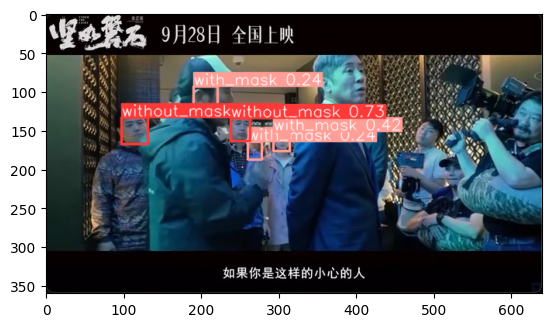

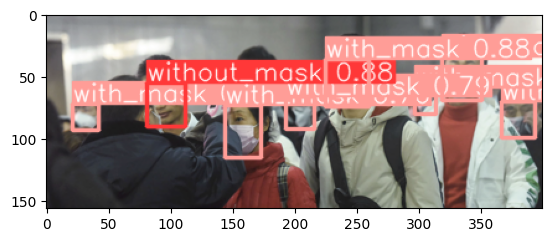

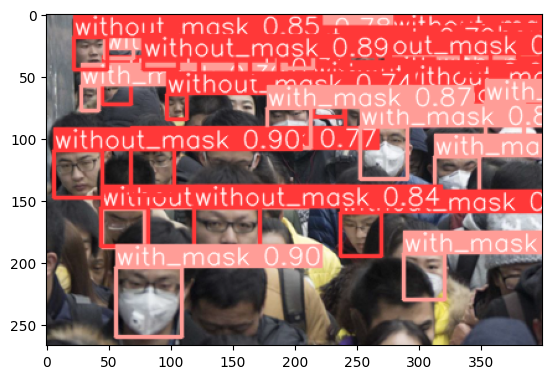

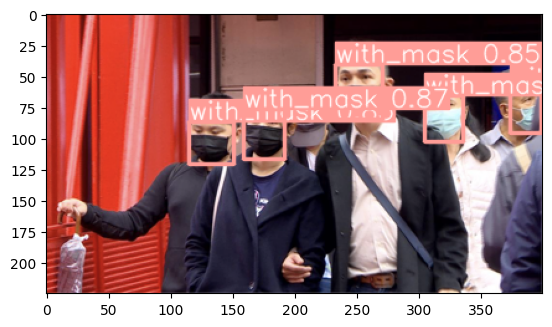

In [8]:
results = []

for image in [
    "../assets/images/1.jpg",
    "../assets/images/maksssksksss1.png",
    "../assets/images/maksssksksss110.png",
    "../assets/images/maksssksksss116.png",
]:
    result = yolov8_detector.predict(
        image,
        save=True,
        conf=0.2,
    )
    results.append(result)

for result in results:
    for r in result:
        im_array = r.plot()  # plot a BGR numpy array of predictions
        im = PIL.Image.fromarray(im_array[..., ::-1])  # RGB PIL image
        plt.imshow(im)
        plt.show()
        # im.show()  # show image
        # im.save("results.jpg")  # save image

In [ ]:
Display(filename=f'./runs/detect/predict2/zidane.jpg', width=600)

In [11]:
import typing as T

import cv2
import numpy as np
import onnxruntime as ort
import torch

# from ultralytics.yolo.utils import ROOT, yaml_load
# from ultralytics.yolo.utils.checks import check_requirements, check_yaml


class Yolov8:
    def __init__(
        self,
        onnx_model: str,
        confidence_thres: float,
        iou_thres: float,
        classes: T.Dict[int, str],
    ):
        """
        Initializes an instance of the Yolov8 class.

        Args:
            onnx_model: Path to the ONNX model.
            input_image: Path to the input image.
            confidence_thres: Confidence threshold for filtering detections.
            iou_thres: IoU (Intersection over Union) threshold for non-maximum suppression.
        """
        self.onnx_model = onnx_model
        self.confidence_thres = confidence_thres
        self.iou_thres = iou_thres

        # Load the class names from the COCO dataset
        # self.classes = yaml_load(check_yaml('coco128.yaml'))['names']
        self.classes = classes
        # 修改分类

        # Generate a color palette for the classes
        self.color_palette = np.random.uniform(0, 255, size=(len(self.classes), 3))

    def draw_detections(self, img, box, score, class_id):
        """
        Draws bounding boxes and labels on the input image based on the detected objects.

        Args:
            img: The input image to draw detections on.
            box: Detected bounding box.
            score: Corresponding detection score.
            class_id: Class ID for the detected object.

        Returns:
            None
        """

        # Extract the coordinates of the bounding box
        x1, y1, w, h = box

        # Retrieve the color for the class ID
        color = self.color_palette[class_id]

        # Draw the bounding box on the image
        cv2.rectangle(img, (int(x1), int(y1)), (int(x1 + w), int(y1 + h)), color, 2)

        # Create the label text with class name and score
        label = f"{self.classes[class_id]}: {score:.2f}"

        # Calculate the dimensions of the label text
        (label_width, label_height), _ = cv2.getTextSize(
            label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1
        )

        # Calculate the position of the label text
        label_x = x1
        label_y = y1 - 10 if y1 - 10 > label_height else y1 + 10

        # Draw a filled rectangle as the background for the label text
        cv2.rectangle(
            img,
            (label_x, label_y - label_height),
            (label_x + label_width, label_y + label_height),
            color,
            cv2.FILLED,
        )

        # Draw the label text on the image
        cv2.putText(
            img,
            label,
            (label_x, label_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 0, 0),
            1,
            cv2.LINE_AA,
        )

    def preprocess(self, input_image):
        """
        Preprocesses the input image before performing inference.

        Returns:
            image_data: Preprocessed image data ready for inference.
        """
        # Read the input image using OpenCV
        # input_image = cv2.imread(input_image)

        # Get the height and width of the input image
        self.img_height, self.img_width = input_image.shape[:2]

        # Convert the image color space from BGR to RGB
        img = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

        # Resize the image to match the input shape
        img = cv2.resize(img, (self.input_width, self.input_height))

        # Normalize the image data by dividing it by 255.0
        image_data = np.array(img) / 255.0

        # Transpose the image to have the channel dimension as the first dimension
        image_data = np.transpose(image_data, (2, 0, 1))  # Channel first

        # Expand the dimensions of the image data to match the expected input shape
        image_data = np.expand_dims(image_data, axis=0).astype(np.float32)

        # Return the preprocessed image data
        return image_data, input_image

    def postprocess(self, input_image, output):
        """
        Performs post-processing on the model's output to extract bounding boxes, scores, and class IDs.

        Args:
            input_image (numpy.ndarray): The input image.
            output (numpy.ndarray): The output of the model.

        Returns:
            numpy.ndarray: The input image with detections drawn on it.
        """

        # Transpose and squeeze the output to match the expected shape
        outputs = np.transpose(np.squeeze(output[0]))

        # Get the number of rows in the outputs array
        rows = outputs.shape[0]

        # Lists to store the bounding boxes, scores, and class IDs of the detections
        boxes = []
        scores = []
        class_ids = []

        # Calculate the scaling factors for the bounding box coordinates
        x_factor = self.img_width / self.input_width
        y_factor = self.img_height / self.input_height

        # Iterate over each row in the outputs array
        for i in range(rows):
            # Extract the class scores from the current row
            classes_scores = outputs[i][4:]

            # Find the maximum score among the class scores
            max_score = np.amax(classes_scores)

            # If the maximum score is above the confidence threshold
            if max_score >= self.confidence_thres:
                # Get the class ID with the highest score
                class_id = np.argmax(classes_scores)

                # Extract the bounding box coordinates from the current row
                x, y, w, h = outputs[i][0], outputs[i][1], outputs[i][2], outputs[i][3]

                # Calculate the scaled coordinates of the bounding box
                left = int((x - w / 2) * x_factor)
                top = int((y - h / 2) * y_factor)
                width = int(w * x_factor)
                height = int(h * y_factor)

                # Add the class ID, score, and box coordinates to the respective lists
                class_ids.append(class_id)
                scores.append(max_score)
                boxes.append([left, top, width, height])

        # Apply non-maximum suppression to filter out overlapping bounding boxes
        indices = cv2.dnn.NMSBoxes(boxes, scores, self.confidence_thres, self.iou_thres)

        # Iterate over the selected indices after non-maximum suppression
        for i in indices:
            # Get the box, score, and class ID corresponding to the index
            box = boxes[i]
            score = scores[i]
            class_id = class_ids[i]
            #  Draw the detection on the input image
            self.draw_detections(input_image, box, score, class_id)

        # Return the modified input image
        return input_image

    def main(self, input_image):
        """
        Performs inference using an ONNX model and returns the output image with drawn detections.

        Returns:
            output_img: The output image with drawn detections.
        """
        # Create an inference session using the ONNX model and specify execution providers
        session = ort.InferenceSession(
            self.onnx_model, providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
        )

        # Get the model inputs
        model_inputs = session.get_inputs()

        # Store the shape of the input for later use
        input_shape = model_inputs[0].shape
        self.input_width = input_shape[2]
        self.input_height = input_shape[3]

        # Preprocess the image data
        img_data, input_image = self.preprocess(input_image)

        # Run inference using the preprocessed image data
        outputs = session.run(None, {model_inputs[0].name: img_data})

        # Perform post-processing on the outputs to obtain output image.
        output_img = self.postprocess(input_image, outputs)

        # Return the resulting output image
        return output_img

In [12]:
model = Yolov8(
    "/Users/zhangzhichao/ML/models/mask-detection.onnx",
    0.2,
    0.5,
    {0: 'without_mask', 1: 'with_mask', 2: 'mask_weared_incorrect'},
)


cap = cv2.VideoCapture("/Users/zhangzhichao/Downloads/坚如磐石.mp4")
# start_time = 5 # skip first {start_time} seconds
# cap.set(cv2.CAP_PROP_POS_FRAMES, start_time * cap.get(cv2.CAP_PROP_FPS))
cv2.namedWindow("Detected Objects", cv2.WINDOW_NORMAL)

while cap.isOpened():
    # Press key q to stop
    if cv2.waitKey(1) == ord("q"):
        break
    try:
        # Read frame from the video
        ret, frame = cap.read()
        if not ret:
            break
    except Exception as e:
        print(e)
        continue
    # Update object localizer
    output_img = model.main(frame)
    cv2.imshow("Detected Objects", output_img)

/Users/zhangzhichao/.pyenv/versions/3.8.16/envs/cv/lib/python3.8/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(
